### Load and compile Crossformer model once

In [1]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

2025-01-22 16:38:47.906345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 16:38:47.906442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 16:38:47.916883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 16:38:48.812050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hylke/miniconda3/envs/crossformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteb

In [2]:
text_goal = "pick up the banana"
task = model.create_tasks(texts=[text_goal])

In [3]:
# dummy inference
import jax
import numpy as np

WINDOW_SIZE = 5

img = np.random.randint(0, 255, size=(224, 224, 3))
input_images = img[None, None].repeat(WINDOW_SIZE, 1)
print(input_images.shape)

observation = {
    "image_primary": input_images,
    "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
}

actions = model.sample_actions(
        observation,
        task,
        head_name="single_arm",
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0),
)
actions = actions[0]  

print(actions.shape)

(1, 5, 224, 224, 3)


(4, 7)


### Start a Pybullet simulation

In [4]:
from environment.utilities import Camera, MultiCams
from environment.env import Environment
from utils import YcbObjects, PackPileData, IsolatedObjData, summarize
import pybullet as p
import numpy as np
import random

from yacs.config import CfgNode as CN

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint
import cv2

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

pybullet build time: Nov 28 2023 23:45:17


In [5]:
runs=1
CAM_Z = 1.9
IMG_SIZE = 224

seed = 429

In [6]:
def dummy_simulation_steps(env,n):
    for _ in range(n):
        p.stepSimulation()

In [7]:
objects = YcbObjects('objects/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'])
objects.shuffle_objects()

#data = IsolatedObjData(objects.obj_names, runs, 'results')

center_x, center_y, center_z = 0.05, -0.52, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40, [0, 1, 0])
# set seed to make sure the tomato soup can is always spawned at same place for development
env = Environment(camera, vis=True, debug=False, finger_length=0.06, seed=seed)

argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Microsoft Corporation
GL_RENDERER=D3D12 (AMD Radeon(TM) Graphics)
GL_VERSION=4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.3
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.3
Vendor = Microsoft Corporation
Renderer = D3D12 (AMD Radeon(TM) Graphics)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Microsoft Corporation
ven = Microsoft Corporation
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:



In [8]:
env.reset_robot()          
env.remove_all_obj()
obj_name = "Banana"                        
               
path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
obj_id = env.load_isolated_obj_return_obj_id(path, mod_orn, mod_stiffness)
dummy_simulation_steps(env, 20)

In [190]:
# get it to better starting position
env.move_gripper(0.085)
env.move_ee([0.1, -0.52, 1.3, (0.0003269339204036837, 0.7162828147217722, -0.0003361126858255739, 0.6978099379320486)])
dummy_simulation_steps(env, 20)

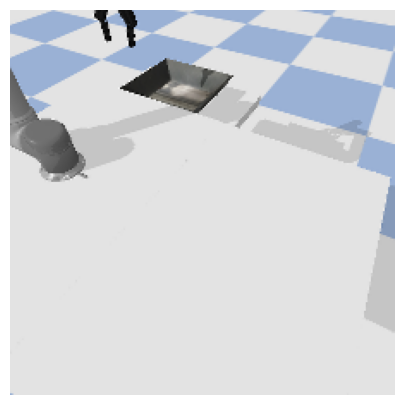

In [ ]:
def get_cfg():
    _C1 = CN()
    _C1.FOCUS_PT = [0.05, -0.52, 0.85]
    _C1.YAW_ANGLES = [-60, 45, -45, 135]
    _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
    _C1.PITCH_ANGLES = [-50, -45, -45, -45]
    return _C1.clone()
    
def render_tmp(env):
        
        def transform_image(image):
            h, w = image.shape[:2]
            # Center crop to 480x480
            start_x = w//2 - 240
            start_y = h//2 - 240
            image = image[start_y:start_y+480, start_x:start_x+480]
            #image = image[:,240:]
            # Resize to 224x224
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            return image

        camera = MultiCams(env.physicsClient, cfg=get_cfg(), n_cams=1)
        rgb, _ = camera.cams[0].get_images(get_rgb=True, get_depth=False, get_seg=False)
        rgb_transformed = transform_image(rgb)
        return rgb_transformed

img = render_tmp(env)
display_image(img, (5,5))

### Test `TrajectoryGenerator` without resetting the Crossformer model

In [9]:
text_goal = "pick up the green ball"
task = model.create_tasks(texts=[text_goal])

In [10]:
# run this cell to re-import TrajectoryGenerator if you make code changes, without having to restart the notebook
import importlib
import trajectory_generator
importlib.reload(trajectory_generator)
from trajectory_generator import TrajectoryGenerator

In [11]:
generator = TrajectoryGenerator(model, task, get_cfg(), 224, 100, 5, make_video=True)

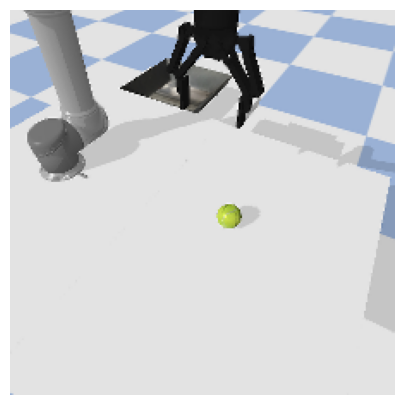

In [14]:
img = generator.render(env)
display_image(img, (5,5))

In [25]:
# duplicated to make testing easier, no need to scroll up

env.reset_robot()          
env.remove_all_obj()
obj_name = "TennisBall"                        
               
path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
obj_id = env.load_isolated_obj_return_obj_id(path, mod_orn, mod_stiffness)
dummy_simulation_steps(env, 20)

In [26]:
# get it to better starting position
env.move_gripper(0.085)
env.move_ee([0.1, -0.52, 1.3, (0.0003269339204036837, 0.7162828147217722, -0.0003361126858255739, 0.6978099379320486)])
dummy_simulation_steps(env, 20)

In [27]:
generator.predict_trajectory(env, obj_id, obj_name)

Action 1/4 in step 1/100.
Took delta action [-9.7386126e-04  2.5300661e-03  2.5108428e-05 -9.9094464e-03
 -2.9017502e-03  1.4439571e-02  9.9447930e-01]


New minimum distance found: 0.5003135361318508 compared to old distance 100000000
Action 2/4 in step 1/100.
Took delta action [-3.5149341e-03  5.7511795e-03 -9.0946071e-04 -1.8847935e-02
 -3.1664113e-03  2.9694855e-02  9.9411792e-01]


New minimum distance found: 0.4997198788144516 compared to old distance 0.5003135361318508
Action 3/4 in step 1/100.
Took delta action [-0.00538893  0.00752699 -0.00165254 -0.02387876 -0.00363556  0.03958024
  0.99738353]


New minimum distance found: 0.49844597886002767 compared to old distance 0.4997198788144516
Action 4/4 in step 1/100.
Took delta action [-0.00577536  0.00745626 -0.00204553 -0.02371175 -0.00400903  0.04208998
  0.99732727]


New minimum distance found: 0.49688356556037705 compared to old distance 0.49844597886002767
Action 1/4 in step 2/100.
Took delta action [-4.1581988e-03  4.76798

In [1]:
p.disconnect()

NameError: name 'p' is not defined

### Results of Crossformer experiments

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


results_file_path = "crossformer_results.csv"

In [61]:
def plot_averaged_values(column_name, ascending=True):
    data = pd.read_csv(results_file_path)
    
    averaged_data = data.groupby('Object Name')[column_name].mean().reset_index()
    averaged_data = averaged_data.sort_values(by=column_name, ascending=ascending)
    
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(averaged_data)))
    
    bars = plt.bar(averaged_data['Object Name'], averaged_data[column_name], color=colors, alpha=0.85)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0, 
            height + 0.02, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    plt.xlabel('Object Name', fontsize=14, labelpad=10)
    plt.ylabel(f'Average {column_name}', fontsize=14, labelpad=10)
    plt.title(f'Average {column_name} per Object', fontsize=16, pad=15)
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_averaged_values_boolean(column_name):
    data = pd.read_csv(results_file_path)
    data[column_name] = data[column_name].astype(bool)

    success_percentages = data.groupby('Object Name')[column_name].mean().reset_index()
    success_percentages[column_name] *= 100  # Convert to percentage
    success_percentages = success_percentages.sort_values(by=column_name, ascending=True)
    
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(success_percentages)))
    
    bars = plt.bar(success_percentages['Object Name'], success_percentages[column_name], color=colors, alpha=0.85)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0, 
            height + 0.02,
            f'{height:.2f}%', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    # Add labels, title, and gridlines
    plt.xlabel('Object Name', fontsize=14, labelpad=10)
    plt.ylabel('Success Percentage (%)', fontsize=14, labelpad=10)
    plt.title('Success Percentage per Object', fontsize=16, pad=15)
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


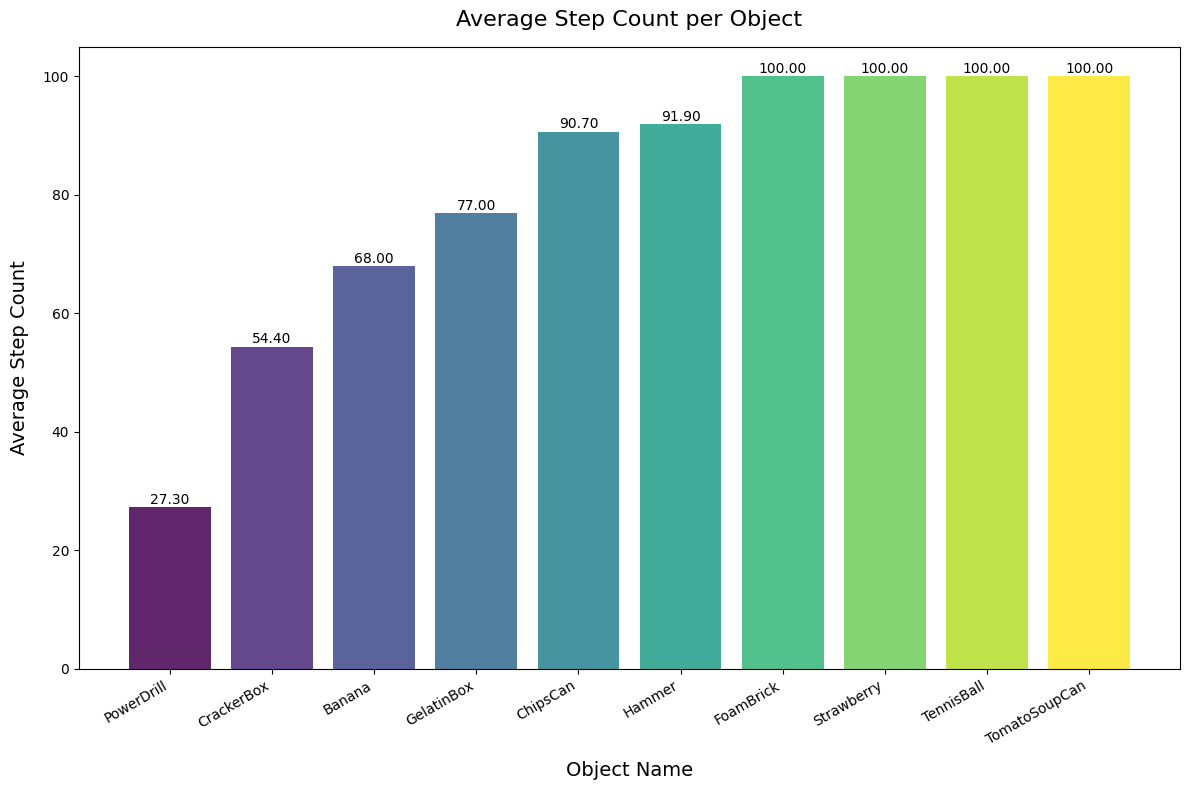

In [68]:
plot_averaged_values("Step Count")

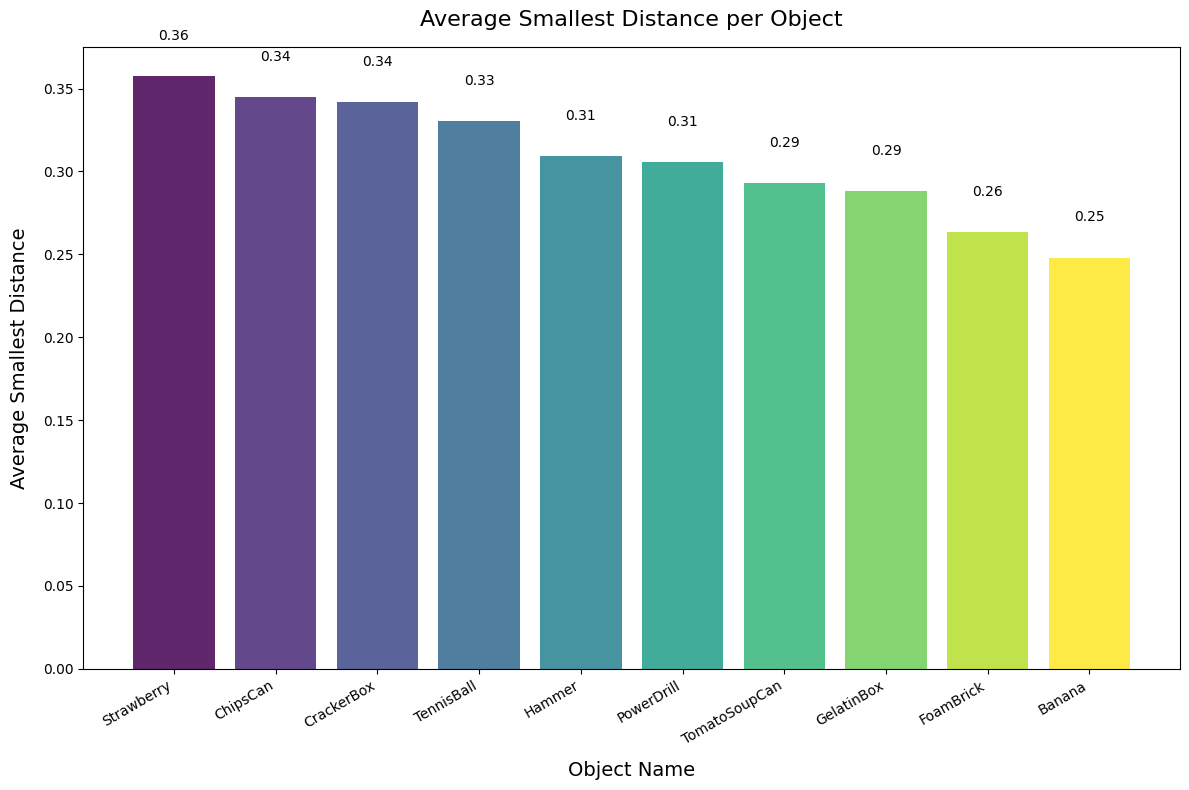

In [67]:
plot_averaged_values("Smallest Distance", False)

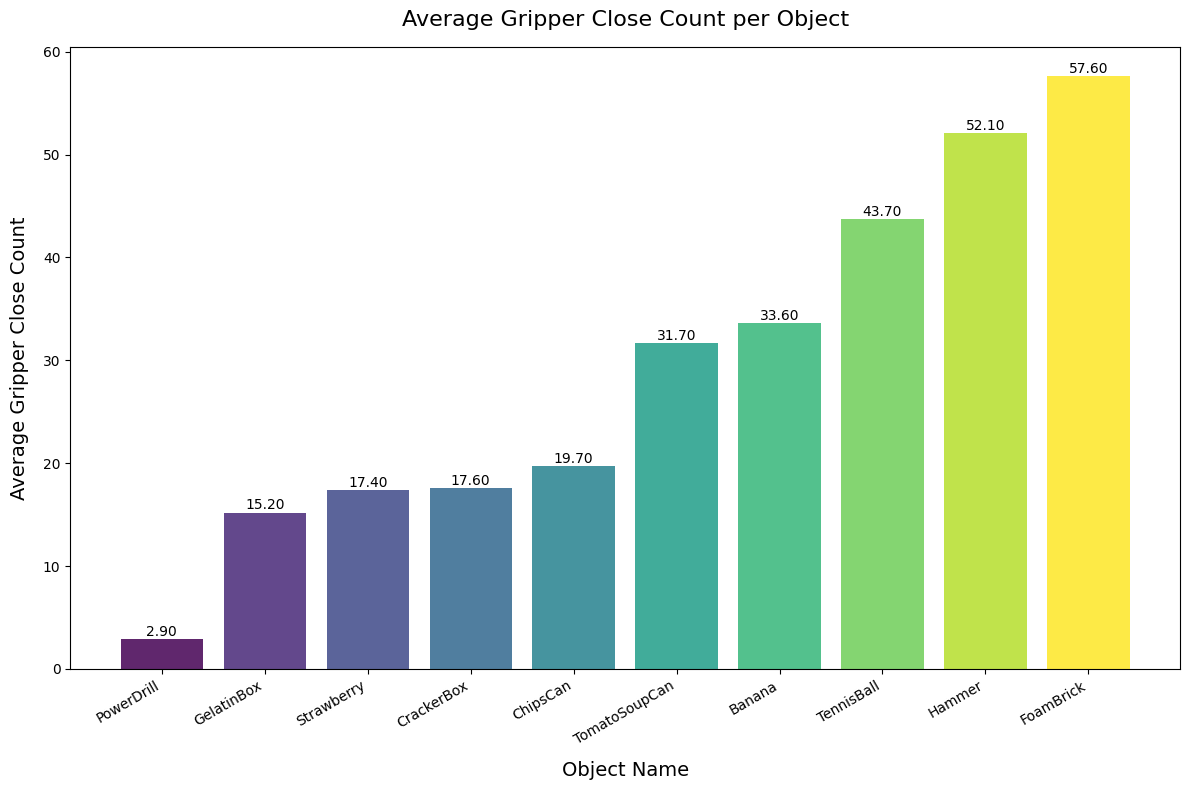

In [69]:
plot_averaged_values("Gripper Close Count")

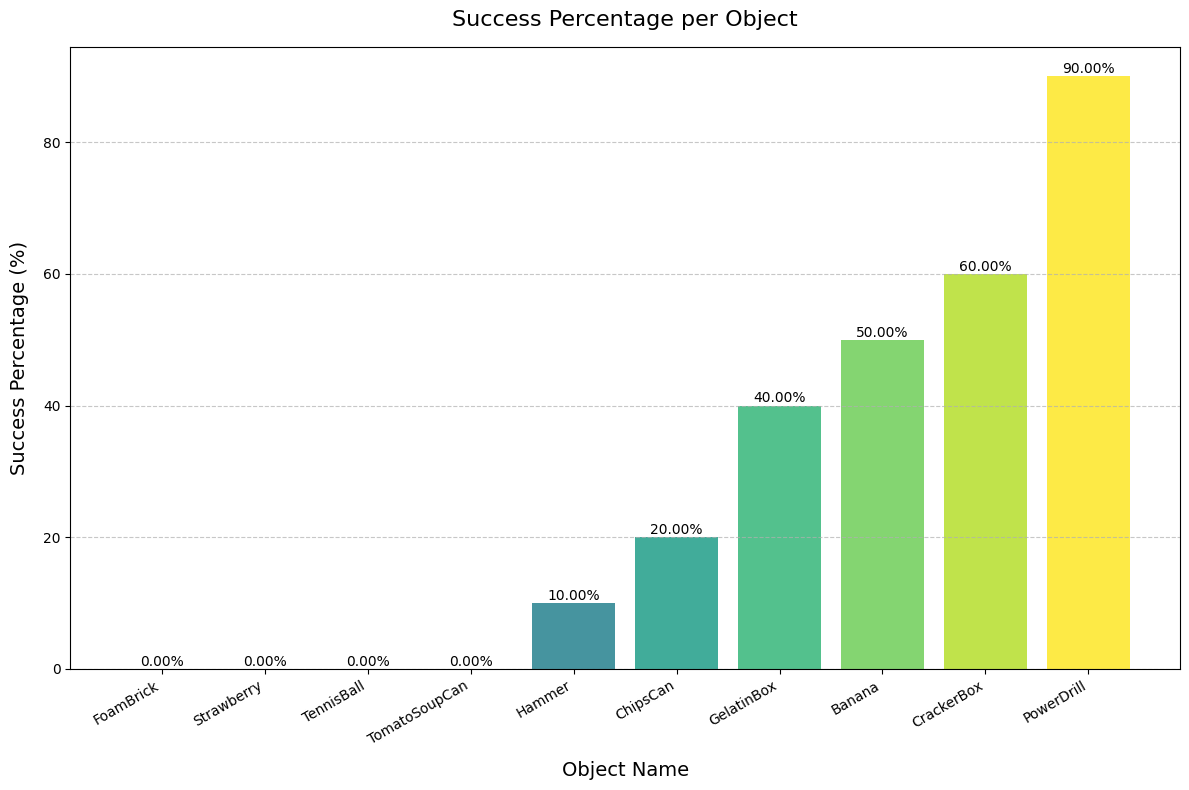

In [58]:
plot_averaged_values_boolean("Success")